In [1]:
from gensim import corpora, models
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import EnglishStemmer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from src.preprocessing import *
from src.feature_reduction import *
from src.classifiers import *
from src.plots import *
from src.CV import *

import time
import gc
import os
import gc
import psutil


import pandas as pd
import matplotlib as mpl
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as prepro
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:

proc = psutil.Process(os.getpid())
mem0 = proc.memory_info().rss

PARAMETERS

In [3]:
sample_size=50000
min_df=15
max_df=0.4
random_state=0
tester = 1

# Step 1

## Data loading

In [4]:
df = pd.read_json(path_or_buf='amazon_step1.json',orient='records',lines=True)

In [156]:
df.shape

(96000, 10)

In [5]:
# TODO remove sampling
# Sampling to minimze computing cost
df = df.sample(sample_size,random_state=random_state)
#df.head()

## Vectorizing the review text

In [6]:
# create a corpus class with an iterator that reads one corpus document per line without loading all into memory
from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import enchant

eng_dic = enchant.Dict("en_US")

lemmatizer = WordNetLemmatizer()
documents = np.array(df['reviewText'])

#print ('original: ',documents[tester], '\n')


In [7]:
#Remove special characters
documents_no_specials=remove_specials_characters(documents)
# remove stop words and tokenize
documents_no_stop= []
for document in documents_no_specials:
    new_text=[]
    for word in document.lower().split():
        if word not in STOPWORDS:
            new_text.append(word)
    documents_no_stop.append(new_text)
    
#print ('tokenize and remove stop words: ',documents_no_stop[tester], '\n')

In [8]:

documents_no_stop_no_numeric = remove_numerical(documents_no_stop)
#print ('remove numerics: ',documents_no_stop_no_numeric[tester], '\n')


In [9]:
# lemmattizing tokens (better than stemming by taking word context into account)
documents_no_stop_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_numeric]

#print ('lemmatize: ',documents_no_stop_no_numeric_lemmatize[tester], '\n')

In [10]:
# remove non-english words
documents_no_stop_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_numeric_lemmatize]

#print ('no english: ',documents_no_stop_no_numeric_lemmatize_english[tester], '\n')

In [11]:
# create ready corpus
df['reviewCleaned'] = [" ".join(doc) for doc in documents_no_stop_no_numeric_lemmatize_english] 


In [12]:
#vectorizer = CountVectorizer(max_df=max_df,min_df=min_df)
vectorizer = CountVectorizer(min_df=2)
vectorizer = TfidfVectorizer(min_df=2)
# fit vectorizer, carry out vectorization and display results
vectorizer.fit(df['reviewCleaned'])
documents_vec = vectorizer.transform(df['reviewCleaned'])
#print(documents_vec) # sparse matrix representation

In [13]:
print(documents_vec)

  (0, 23082)	0.0773275678559
  (0, 22951)	0.166046761689
  (0, 22639)	0.0540658128102
  (0, 22505)	0.0531076418332
  (0, 22391)	0.0492957842987
  (0, 22390)	0.0375200286621
  (0, 21965)	0.0537765901532
  (0, 21956)	0.0596250780413
  (0, 21500)	0.074149978232
  (0, 21251)	0.117420022469
  (0, 21231)	0.042988352598
  (0, 20916)	0.0563298010266
  (0, 20801)	0.0747050890046
  (0, 20699)	0.0716266613476
  (0, 20593)	0.0368637369188
  (0, 20247)	0.0706154064267
  (0, 19717)	0.0515747490603
  (0, 19573)	0.108293707387
  (0, 19572)	0.0622990905558
  (0, 19398)	0.0977342977335
  (0, 19167)	0.0649636409747
  (0, 18603)	0.055393884448
  (0, 18602)	0.0411370910549
  (0, 18386)	0.0872184271258
  (0, 18130)	0.0641676923288
  :	:
  (49997, 3726)	0.190139668155
  (49997, 2332)	0.190897261999
  (49997, 2198)	0.16112861673
  (49997, 1904)	0.189491297727
  (49997, 1040)	0.192368440666
  (49997, 1017)	0.174160267018
  (49997, 291)	0.184107366473
  (49998, 23002)	0.207304504661
  (49998, 22450)	0.301642053

In [14]:
proc = psutil.Process(os.getpid())
mem1 = proc.memory_info().rss
del lemmatizer, document,documents,documents_no_specials,documents_no_stop,documents_no_stop_no_numeric
del documents_no_stop_no_numeric_lemmatize,documents_no_stop_no_numeric_lemmatize_english, eng_dic
mem2 = proc.memory_info().rss
gc.collect()
mem3 = proc.memory_info().rss
pdf = lambda x2, x1: 100.0 * (x2 - x1) / mem0
print ("Allocation: %0.2f%%" % pdf(mem1, mem0))
print ("Unreference: %0.2f%%" % pdf(mem2, mem1))
print ("Collect: %0.2f%%" % pdf(mem3, mem2))
print ("Overall: %0.2f%%" % pdf(mem3, mem0))




Allocation: 344.08%
Unreference: -73.27%
Collect: -0.34%
Overall: 270.47%


## Category Prediction 

### Pre-Processing

X is the review word vector. y are the corresponding categories.

The data is Min/max scaled into [0;1]. It isn't standartize because we want positive values. One could try a normalization (l1 or l2 for example)

We split the data into a train and test set. 

tf/idf is not relevant since words that appear often might suggest a category (such as 'book')

In [15]:
y=df['category']
categories=np.unique(y)
#X_scaled=preprocessing.normalize(documents_vec,norm='max', copy=False)
proc.memory_info().rss
X_scaled=documents_vec

In [16]:
X_train=X_scaled
y_train=y

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state)

In [18]:
proc.memory_info().rss

576946176

In [171]:
# Numpy arrays
#X_train=np.array(X_train)
#X_test=np.array(X_test)
#y_train=np.array(y_train)
#y_test=np.array(y_test)

### Trying Feature selection

#### select k best

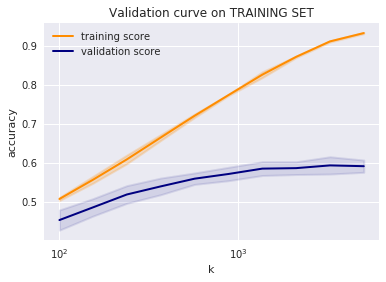

Best k = 3244 with score : 0.593
Execution time : 54.9113392829895 seconds


In [24]:
from sklearn.feature_selection import SelectKBest
parameter_search_feature_selection(LogisticRegression(C=0.74438, n_jobs=-1),SelectKBest(),'k',np.logspace(2,3.7,10).astype(int),
                                   X_train,y_train,random_state=random_state,save_fig='output_figs/slt_k_bst.png')

#### Latent Semantic Indexing

In [55]:
X_train_concepts,X_test_concepts = LSI_concepts(X_train,X_test,num_lsi_topics = 100,words=vectorizer.get_feature_names())

In [82]:
start = time.time()

y_pred=cosine_pred(X_train_concepts,X_test_concepts,y_train,categories)
print("accuracy:",accuracy_score(y_test,y_pred))

end=time.time()
print("Execution time : {} seconds".format(end-start))

0
100
200
300
400
500
600
700
800
900
accuracy: 0.417
Execution time : 15.908146142959595 seconds


25
0
100
200
300
400
500
600
700
800
900
accuracy: 0.297
30
0
100
200
300
400
500
600
700
800
900
accuracy: 0.298
35
0
100
200
300
400
500
600
700
800
900
accuracy: 0.31
40
0
100
200
300
400
500
600
700
800
900
accuracy: 0.323
50
0
100
200
300
400
500
600
700
800
900
accuracy: 0.345
60
0
100
200
300
400
500
600
700
800
900
accuracy: 0.376
70
0
100
200
300
400
500
600
700
800
900
accuracy: 0.385
80
0
100
200
300
400
500
600
700
800
900
accuracy: 0.393
90
0
100
200
300
400
500
600
700
800
900
accuracy: 0.424
100
0
100
200
300
400
500
600
700
800
900
accuracy: 0.424
200
0
100
200
300
400
500
600
700
800
900
accuracy: 0.465
300
0
100
200
300
400
500
600
700
800
900
accuracy: 0.477
400
0
100
200
300
400
500
600
700
800
900
accuracy: 0.489
500
0
100
200
300
400
500
600
700
800
900
accuracy: 0.494
600
0
100
200
300
400
500
600
700
800
900
accuracy: 0.501
700
0
100
200
300
400
500
600
700
800
900
accuracy: 0.502
800
0
100
200
300
400
500
600
700
800
900
accuracy: 0.502
900
0
100
200
300
400
50

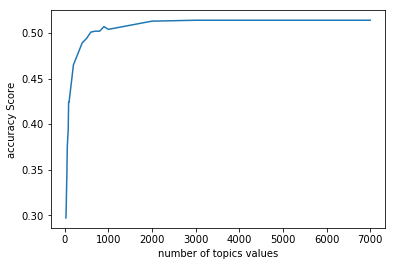

Execution time : 3555.529062271118 seconds
best num_lsi_topics= 3000 with accuracy score: 0.514


In [83]:
start=time.time()

accuracy=[]
num_lsi_topics_array = [25,30,35,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000]
# Check various C
for num_lsi_topics in num_lsi_topics_array:
    print(num_lsi_topics)
    # fit classifier 
    X_train_concepts,X_test_concepts = LSI_concepts(X_train,X_test,num_lsi_topics,words=vectorizer.get_feature_names())
    
    y_pred=cosine_pred(X_train_concepts,X_test_concepts,y_train, categories)
    print("accuracy:",accuracy_score(y_test,y_pred))
    accuracy.append(accuracy_score(y_test,y_pred))

# Plot
plt.plot(num_lsi_topics_array,accuracy)
plt.ylabel("accuracy Score")
plt.xlabel("number of topics values")
plt.show()

end=time.time()
print("Execution time : {} seconds".format(end-start))
best_c=num_lsi_topics_array[np.argmax(accuracy)]
print("best num_lsi_topics=",best_c,"with accuracy score:", np.max(accuracy))

#### Latent Dirichlet Allocation LDA

In [59]:
# USE LSI number of concepts and then tune update every and passes
start = time.time()
X_train_concepts,X_test_concepts = LDA_concepts(X_train,X_test,num_lda_topics = 100,words=vectorizer.get_feature_names())
y_pred=cosine_pred(X_train_concepts,X_test_concepts,y_train,categories)
print("accuracy:",accuracy_score(y_test,y_pred))

end=time.time()
print("Execution time : {} seconds".format(end-start))

KeyboardInterrupt: 

In [ ]:
start=time.time()

accuracy=[]
num_lda_topics_array = [25,30,35,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000]
# Check various C
for num_lda_topics in num_lda_topics_array:
    print(num_lda_topics)
    # fit classifier 
    X_train_concepts,X_test_concepts = LDA_concepts(X_train,X_test,num_lsi_topics,words=vectorizer.get_feature_names())
    
    y_pred=cosine_pred(X_train_concepts,X_test_concepts,y_train, categories)
    print("accuracy:",accuracy_score(y_test,y_pred))
    accuracy.append(accuracy_score(y_test,y_pred))

# Plot
plt.plot(num_lda_topics_array,accuracy)
plt.ylabel("accuracy Score")
plt.xlabel("Number of topics values")
plt.show()

end=time.time()
print("Execution time : {} seconds".format(end-start))
best_c=num_lsi_topics_array[np.argmax(accuracy)]
print("best num_lsi_topics=",best_c,"with accuracy score:", np.max(accuracy))

### Classifying

#### dummy classifier

Baseline model: Assign the categories randomly.

In [18]:
from sklearn.dummy import DummyClassifier
dmy=DummyClassifier(random_state=random_state)
dmy.fit(X_train,y_train)
y_pred=dmy.predict(X_test)
print("accuracy:",accuracy_score(y_test,y_pred))

accuracy: 0.049


#### Cosine similarity

For each category  we regroup the documents belonging to this category together. Then for each element we want to predict, we check how similar it is compared to each group (cosine similarity). The most similar group gives the category to the element.

In [23]:

from sklearn.model_selection import cross_val_score


start= time.time()
cosine_classifier=Cosine_sim(categories)
print("Mean CV valdiation score:",np.mean(cross_val_score(
    cosine_classifier,X_train,y_train,scoring='accuracy',cv=5,verbose=2,n_jobs=-1)))
end=time.time()
print("Execution time : {} seconds".format(end-start))



[CV]  ................................................................
[CV]  ................................................................
0
[CV]  ................................................................
0
[CV]  ................................................................
0
[CV]  ................................................................
0
0
100
100
100
100
100
200
200
200
200
200
300
300
300
300
300
400
400
400
400
400
500
500
500
500
500
600
600
600
600
600
700
700
700
700
700
[CV] ................................................. , total=14.7min
[CV] ................................................. , total=14.9min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.9min remaining: 22.3min


[CV] ................................................. , total=14.9min
[CV] ................................................. , total=15.3min
[CV] ................................................. , total=15.3min
Mean CV valdiation score: 0.5125
Execution time : 920.8456282615662 seconds


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.3min finished


5000 samples Mean CV valdiation score: 0.5125
Execution time : 920.8456282615662 seconds

#### Decision tree

Try various maximum depths for a classic decision tree classifier

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_depth=1 .....................................................
[CV] max_depth=1 .....................................................
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   1.3s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   1.3s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   1.3s
[CV] max_depth=11 ....................................................
[CV] ...................................... max_depth=1, total=   1.2s
[CV] max_depth=11 ....................................................
[CV] ...................................... max_depth=1, total=   1.3s
[CV] max_depth=11 ....................................................
[CV] max_depth=

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   55.3s


[CV] max_depth=61 ....................................................
[CV] ..................................... max_depth=51, total=  23.3s
[CV] max_depth=61 ....................................................
[CV] ..................................... max_depth=51, total=  23.5s
[CV] max_depth=61 ....................................................
[CV] ..................................... max_depth=51, total=  23.1s
[CV] max_depth=71 ....................................................
[CV] ..................................... max_depth=51, total=  24.5s
[CV] max_depth=71 ....................................................
[CV] ..................................... max_depth=51, total=  24.3s
[CV] max_depth=71 ....................................................
[CV] ..................................... max_depth=61, total=  25.7s
[CV] max_depth=71 ....................................................
[CV] ..................................... max_depth=61, total=  25.5s
[CV] m

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.7min


[CV] .................................... max_depth=291, total=  33.9s
[CV] max_depth=301 ...................................................
[CV] .................................... max_depth=291, total=  32.0s
[CV] max_depth=311 ...................................................
[CV] .................................... max_depth=291, total=  30.0s
[CV] max_depth=311 ...................................................
[CV] .................................... max_depth=291, total=  32.2s
[CV] max_depth=311 ...................................................
[CV] .................................... max_depth=301, total=  29.4s
[CV] max_depth=311 ...................................................
[CV] .................................... max_depth=301, total=  34.6s
[CV] max_depth=311 ...................................................
[CV] .................................... max_depth=301, total=  29.7s
[CV] max_depth=321 ...................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 12.2min finished


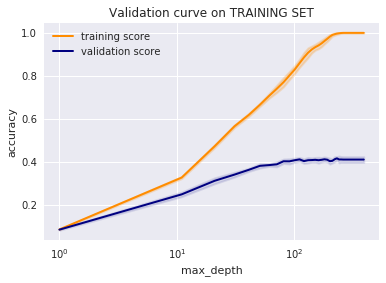

Best ['max_depth'] = {'max_depth': 231} with score : 0.41575
Execution time : 755.4045288562775 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 400, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [46]:
parameter_search(DecisionTreeClassifier(random_state=random_state),
                {'max_depth':range(1,400,10)},
                X_train,
                y_train,save_file='output_figs/decision tree.png')

5000: Best ['max_depth'] = {'max_depth': 231} with score : 0.41575
Execution time : 755.4045288562775 seconds

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] max_depth=150 ...................................................
[CV] max_depth=150 ...................................................
[CV] max_depth=150 ...................................................
[CV] max_depth=150 ...................................................
[CV] max_depth=150 ...................................................
[CV] max_depth=160 ...................................................
[CV] max_depth=160 ...................................................
[CV] max_depth=160 ...................................................
[CV] .................................... max_depth=150, total=  36.7s
[CV] max_depth=160 ...................................................
[CV] .................................... max_depth=160, total=  37.3s
[CV] max_depth=160 ...................................................
[CV] .................................... max_depth=150, total=  38.0s
[CV] max_depth=

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min


[CV] .................................... max_depth=200, total=  34.0s
[CV] max_depth=210 ...................................................
[CV] .................................... max_depth=200, total=  35.4s
[CV] max_depth=210 ...................................................
[CV] .................................... max_depth=200, total=  35.4s
[CV] max_depth=220 ...................................................
[CV] .................................... max_depth=200, total=  35.5s
[CV] max_depth=220 ...................................................
[CV] .................................... max_depth=210, total=  35.3s
[CV] max_depth=220 ...................................................
[CV] .................................... max_depth=210, total=  34.7s
[CV] max_depth=220 ...................................................
[CV] .................................... max_depth=200, total=  36.2s
[CV] max_depth=220 ...................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.7min


[CV] .................................... max_depth=440, total=  38.3s
[CV] max_depth=450 ...................................................
[CV] .................................... max_depth=440, total=  38.6s
[CV] max_depth=460 ...................................................
[CV] .................................... max_depth=440, total=  38.1s
[CV] max_depth=460 ...................................................
[CV] .................................... max_depth=440, total=  38.9s
[CV] max_depth=460 ...................................................
[CV] .................................... max_depth=450, total=  38.5s
[CV] max_depth=460 ...................................................
[CV] .................................... max_depth=450, total=  36.7s
[CV] max_depth=460 ...................................................
[CV] .................................... max_depth=450, total=  37.9s
[CV] max_depth=470 ...................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 17.8min finished
/home/adrikiri/project-pace-mourad/adrian/src/plots.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if train_scores_std != None and val_scores_std != None:
/home/adrikiri/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


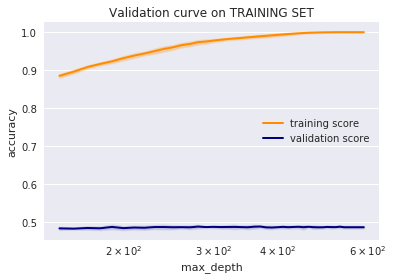

Best ['max_depth'] = {'max_depth': 370} with score : 0.48875
Execution time : 1110.799497127533 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(150, 600, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [29]:
parameter_search(DecisionTreeClassifier(random_state=random_state),
                {'max_depth':range(150,600,10)},
                X_train,
                y_train,save_file='output_figs/decision tree_more_accurate.png')

#### k nearest neighbors

In [19]:
from sklearn.neighbors import KNeighborsClassifier

parameter_search(KNeighborsClassifier(),
                {'n_neighbors':range(1,50,3)},
                X_train,
                y_train,save_file='output_figs/knn.png')


Fitting 5 folds for each of 17 candidates, totalling 85 fits
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=4 ...................................................
[CV] n_neighbors=4 ...................................................
[CV] n_neighbors=4 ...................................................
[CV] n_neighbors=4 ...................................................
[CV] n_neighbors=4 ...................................................
[CV] n_neighbors=7 ...................................................
[CV] n_neighbors=7 ...................................................
[CV] n_neighbors=7 ...................................................
[CV] n_neighbors

JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f3dbd2851e0, file "/...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/adriki.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f3dbd2851e0, file "/...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/adriki.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.neighbors import KNeighborsClassifi...        y_train,save_file='output_figs/knn.png')\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-05-20T20:37:47.891365', 'msg_id': '794D5A019E7540808B07279EC4023F8A', 'msg_type': 'execute_request', 'session': '3DB3021C17D14CA789B03AD82867CDC8', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '794D5A019E7540808B07279EC4023F8A', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'3DB3021C17D14CA789B03AD82867CDC8']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.neighbors import KNeighborsClassifi...        y_train,save_file='output_figs/knn.png')\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-05-20T20:37:47.891365', 'msg_id': '794D5A019E7540808B07279EC4023F8A', 'msg_type': 'execute_request', 'session': '3DB3021C17D14CA789B03AD82867CDC8', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '794D5A019E7540808B07279EC4023F8A', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'3DB3021C17D14CA789B03AD82867CDC8'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.neighbors import KNeighborsClassifi...        y_train,save_file='output_figs/knn.png')\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-05-20T20:37:47.891365', 'msg_id': '794D5A019E7540808B07279EC4023F8A', 'msg_type': 'execute_request', 'session': '3DB3021C17D14CA789B03AD82867CDC8', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '794D5A019E7540808B07279EC4023F8A', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="from sklearn.neighbors import KNeighborsClassifi...        y_train,save_file='output_figs/knn.png')\n", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "from sklearn.neighbors import KNeighborsClassifi...        y_train,save_file='output_figs/knn.png')\n"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("from sklearn.neighbors import KNeighborsClassifi...        y_train,save_file='output_figs/knn.png')\n",), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("from sklearn.neighbors import KNeighborsClassifi...        y_train,save_file='output_figs/knn.png')\n",)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from sklearn.neighbors import KNeighborsClassifi...        y_train,save_file='output_figs/knn.png')\n", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Expr object>], cell_name='<ipython-input-19-6acee8d0fc7c>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f3d649234a8, executi..._before_exec=None error_in_exec=None result=None>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f3d4d3278a0, file "<ipython-input-19-6acee8d0fc7c>", line 3>
        result = <ExecutionResult object at 7f3d649234a8, executi..._before_exec=None error_in_exec=None result=None>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f3d4d3278a0, file "<ipython-input-19-6acee8d0fc7c>", line 3>, result=<ExecutionResult object at 7f3d649234a8, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f3d4d3278a0, file "<ipython-input-19-6acee8d0fc7c>", line 3>
        self.user_global_ns = {'Cosine_sim': <class 'src.classifiers.Cosine_sim'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'EnglishStemmer': <class 'nltk.stem.snowball.EnglishStemmer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "from gensim import corpora, models\nfrom sklearn....load 2')\nget_ipython().magic('matplotlib inline')", '\nproc = psutil.Process(os.getpid())\nmem0 = proc.memory_info().rss', 'sample_size=50000\nmin_df=15\nmax_df=0.4\nrandom_state=0\ntester = 1', "df = pd.read_json(path_or_buf='amazon_step1.json',orient='records',lines=True)", '# TODO remove sampling\n# Sampling to minimze com...sample_size,random_state=random_state)\n#df.head()', "# create a corpus class with an iterator that re...])\n\n#print ('original: ',documents[tester], '\\n')", "#Remove special characters\ndocuments_no_specials...ve stop words: ',documents_no_stop[tester], '\\n')", "\ndocuments_no_stop_no_numeric = remove_numerical...cs: ',documents_no_stop_no_numeric[tester], '\\n')", r"# lemmattizing tokens (better than stemming by t...ments_no_stop_no_numeric_lemmatize[tester], '\n')", "# remove non-english words\ndocuments_no_stop_no_..._stop_no_numeric_lemmatize_english[tester], '\\n')", '# create ready corpus\ndf[\'reviewCleaned\'] = [" "... documents_no_stop_no_numeric_lemmatize_english] ', '#vectorizer = CountVectorizer(max_df=max_df,min_...int(documents_vec) # sparse matrix representation', 'print(documents_vec)', 'proc = psutil.Process(os.getpid())\nmem1 = proc.m...m2))\nprint ("Overall: %0.2f%%" % pdf(mem3, mem0))', "y=df['category']\ncategories=np.unique(y)\n#X_scal...se)\nproc.memory_info().rss\nX_scaled=documents_vec", 'X_train=X_scaled\ny_train=y', 'X_train, X_test, y_train, y_test = train_test_sp...led, y, test_size=0.2, random_state=random_state)', 'proc.memory_info().rss', "from sklearn.neighbors import KNeighborsClassifi...         y_train,save_file='output_figs/knn.png')"], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LDA_concepts': <function LDA_concepts>, 'LSI_concepts': <function LSI_concepts>, ...}
        self.user_ns = {'Cosine_sim': <class 'src.classifiers.Cosine_sim'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'EnglishStemmer': <class 'nltk.stem.snowball.EnglishStemmer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "from gensim import corpora, models\nfrom sklearn....load 2')\nget_ipython().magic('matplotlib inline')", '\nproc = psutil.Process(os.getpid())\nmem0 = proc.memory_info().rss', 'sample_size=50000\nmin_df=15\nmax_df=0.4\nrandom_state=0\ntester = 1', "df = pd.read_json(path_or_buf='amazon_step1.json',orient='records',lines=True)", '# TODO remove sampling\n# Sampling to minimze com...sample_size,random_state=random_state)\n#df.head()', "# create a corpus class with an iterator that re...])\n\n#print ('original: ',documents[tester], '\\n')", "#Remove special characters\ndocuments_no_specials...ve stop words: ',documents_no_stop[tester], '\\n')", "\ndocuments_no_stop_no_numeric = remove_numerical...cs: ',documents_no_stop_no_numeric[tester], '\\n')", r"# lemmattizing tokens (better than stemming by t...ments_no_stop_no_numeric_lemmatize[tester], '\n')", "# remove non-english words\ndocuments_no_stop_no_..._stop_no_numeric_lemmatize_english[tester], '\\n')", '# create ready corpus\ndf[\'reviewCleaned\'] = [" "... documents_no_stop_no_numeric_lemmatize_english] ', '#vectorizer = CountVectorizer(max_df=max_df,min_...int(documents_vec) # sparse matrix representation', 'print(documents_vec)', 'proc = psutil.Process(os.getpid())\nmem1 = proc.m...m2))\nprint ("Overall: %0.2f%%" % pdf(mem3, mem0))', "y=df['category']\ncategories=np.unique(y)\n#X_scal...se)\nproc.memory_info().rss\nX_scaled=documents_vec", 'X_train=X_scaled\ny_train=y', 'X_train, X_test, y_train, y_test = train_test_sp...led, y, test_size=0.2, random_state=random_state)', 'proc.memory_info().rss', "from sklearn.neighbors import KNeighborsClassifi...         y_train,save_file='output_figs/knn.png')"], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LDA_concepts': <function LDA_concepts>, 'LSI_concepts': <function LSI_concepts>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/adrikiri/project-pace-mourad/adrian/<ipython-input-19-6acee8d0fc7c> in <module>()
      1 from sklearn.neighbors import KNeighborsClassifier
      2 
      3 parameter_search(KNeighborsClassifier(),
      4                 {'n_neighbors':range(1,50,3)},
      5                 X_train,
----> 6                 y_train,save_file='output_figs/knn.png')
      7 
      8 
      9 
     10 

...........................................................................
/home/adrikiri/project-pace-mourad/adrian/src/CV.py in parameter_search(estimator=KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=5, p=2,
           weights='uniform'), param_grid={'n_neighbors': range(1, 50, 3)}, X_train=<40000x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y_train=58034                 Digital_Music
14527       ...               Baby
Name: category, dtype: object, cv=5, scoring='accuracy', verbose=2, save_file='output_figs/knn.png', n_jobs=-1)
     28         param_range.append(param_grid[key])
     29     #param_name = param_grid.keys()
     30     
     31     #param_range = param_grid.values()
     32     gsCV = GridSearchCV(estimator, param_grid, cv=cv, scoring=scoring, verbose=verbose,n_jobs=n_jobs)
---> 33     gsCV.fit(X_train, y_train)
        gsCV.fit = <bound method GridSearchCV.fit of GridSearchCV(c...core=True,
       scoring='accuracy', verbose=2)>
        X_train = <40000x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        y_train = 58034                 Digital_Music
14527       ...               Baby
Name: category, dtype: object
     34     val_scores_mean = gsCV.cv_results_['mean_test_score']
     35     val_scores_std = gsCV.cv_results_['std_test_score']
     36     train_scores_mean = gsCV.cv_results_['mean_train_score']
     37     train_scores_std = gsCV.cv_results_['std_train_score']

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...score=True,
       scoring='accuracy', verbose=2), X=<40000x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y=58034                 Digital_Music
14527       ...               Baby
Name: category, dtype: object, groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...core=True,
       scoring='accuracy', verbose=2)>
        X = <40000x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        y = 58034                 Digital_Music
14527       ...               Baby
Name: category, dtype: object
        groups = None
        self.param_grid = {'n_neighbors': range(1, 50, 3)}
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in _fit(self=GridSearchCV(cv=5, error_score='raise',
       e...score=True,
       scoring='accuracy', verbose=2), X=<40000x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y=58034                 Digital_Music
14527       ...               Baby
Name: category, dtype: object, groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Sat May 20 20:37:57 2017
PID: 2451                 Python 3.6.0: /home/adrikiri/anaconda3/bin/python
...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform'), <40000x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 58034                 Digital_Music
14527       ...               Baby
Name: category, dtype: object, make_scorer(accuracy_score), array([ 7333,  7356,  7391, ..., 39997, 39998, 39999]), array([   0,    1,    2, ..., 8635, 8673, 8678]), 2, {'n_neighbors': 1}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform'), <40000x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 58034                 Digital_Music
14527       ...               Baby
Name: category, dtype: object, make_scorer(accuracy_score), array([ 7333,  7356,  7391, ..., 39997, 39998, 39999]), array([   0,    1,    2, ..., 8635, 8673, 8678]), 2, {'n_neighbors': 1})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform'), X=<40000x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y=58034                 Digital_Music
14527       ...               Baby
Name: category, dtype: object, scorer=make_scorer(accuracy_score), train=array([ 7333,  7356,  7391, ..., 39997, 39998, 39999]), test=array([   0,    1,    2, ..., 8635, 8673, 8678]), verbose=2, parameters={'n_neighbors': 1}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform')
        X_test = <8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        y_test = 58034                 Digital_Music
14527       ...Sports_and_Outdoors
Name: category, dtype: object
        scorer = make_scorer(accuracy_score)
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _score(estimator=KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform'), X_test=<8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, y_test=58034                 Digital_Music
14527       ...Sports_and_Outdoors
Name: category, dtype: object, scorer=make_scorer(accuracy_score))
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(accuracy_score)
        estimator = KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform')
        X_test = <8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        y_test = 58034                 Digital_Music
14527       ...Sports_and_Outdoors
Name: category, dtype: object
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(accuracy_score), estimator=KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform'), X=<8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, y_true=58034                 Digital_Music
14527       ...Sports_and_Outdoors
Name: category, dtype: object, sample_weight=None)
     86         score : float
     87             Score function applied to prediction of estimator on X.
     88         """
     89         super(_PredictScorer, self).__call__(estimator, X, y_true,
     90                                              sample_weight=sample_weight)
---> 91         y_pred = estimator.predict(X)
        y_pred = undefined
        estimator.predict = <bound method KNeighborsClassifier.predict of KN..._neighbors=1, p=2,
           weights='uniform')>
        X = <8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
     92         if sample_weight is not None:
     93             return self._sign * self._score_func(y_true, y_pred,
     94                                                  sample_weight=sample_weight,
     95                                                  **self._kwargs)

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/classification.py in predict(self=KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform'), X=<8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>)
    140         y : array of shape [n_samples] or [n_samples, n_outputs]
    141             Class labels for each data sample.
    142         """
    143         X = check_array(X, accept_sparse='csr')
    144 
--> 145         neigh_dist, neigh_ind = self.kneighbors(X)
        neigh_dist = undefined
        neigh_ind = undefined
        self.kneighbors = <bound method KNeighborsMixin.kneighbors of KNei..._neighbors=1, p=2,
           weights='uniform')>
        X = <8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
    146 
    147         classes_ = self.classes_
    148         _y = self._y
    149         if not self.outputs_2d_:

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py in kneighbors(self=KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=1, p=2,
           weights='uniform'), X=<8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, n_neighbors=1, return_distance=True)
    348         n_jobs = _get_n_jobs(self.n_jobs)
    349         if self._fit_method == 'brute':
    350             # for efficiency, use squared euclidean distances
    351             if self.effective_metric_ == 'euclidean':
    352                 dist = pairwise_distances(X, self._fit_X, 'euclidean',
--> 353                                           n_jobs=n_jobs, squared=True)
        n_jobs = 1
    354             else:
    355                 dist = pairwise_distances(
    356                     X, self._fit_X, self.effective_metric_, n_jobs=n_jobs,
    357                     **self.effective_metric_params_)

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py in pairwise_distances(X=<8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, Y=<31991x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, metric='euclidean', n_jobs=1, **kwds={'squared': True})
   1235         if n_jobs == 1 and X is Y:
   1236             return distance.squareform(distance.pdist(X, metric=metric,
   1237                                                       **kwds))
   1238         func = partial(distance.cdist, metric=metric, **kwds)
   1239 
-> 1240     return _parallel_pairwise(X, Y, func, n_jobs, **kwds)
        X = <8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        Y = <31991x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        func = <function euclidean_distances>
        n_jobs = 1
        kwds = {'squared': True}
   1241 
   1242 
   1243 # These distances recquire boolean arrays, when using scipy.spatial.distance
   1244 PAIRWISE_BOOLEAN_FUNCTIONS = [

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py in _parallel_pairwise(X=<8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, Y=<31991x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, func=<function euclidean_distances>, n_jobs=1, **kwds={'squared': True})
   1078     if Y is None:
   1079         Y = X
   1080 
   1081     if n_jobs == 1:
   1082         # Special case to avoid picklability checks in delayed
-> 1083         return func(X, Y, **kwds)
        func = <function euclidean_distances>
        X = <8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        Y = <31991x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        kwds = {'squared': True}
   1084 
   1085     # TODO: in some cases, backend='threading' may be appropriate
   1086     fd = delayed(func)
   1087     ret = Parallel(n_jobs=n_jobs, verbose=0)(

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py in euclidean_distances(X=<8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, Y=<31991x23098 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, Y_norm_squared=None, squared=True, X_norm_squared=None)
    240             raise ValueError(
    241                 "Incompatible dimensions for Y and Y_norm_squared")
    242     else:
    243         YY = row_norms(Y, squared=True)[np.newaxis, :]
    244 
--> 245     distances = safe_sparse_dot(X, Y.T, dense_output=True)
        distances = undefined
        X = <8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        Y.T = <23098x31991 sparse matrix of type '<class 'nump...ored elements in Compressed Sparse Column format>
    246     distances *= -2
    247     distances += XX
    248     distances += YY
    249     np.maximum(distances, 0, out=distances)

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/sklearn/utils/extmath.py in safe_sparse_dot(a=<8009x23098 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, b=<23098x31991 sparse matrix of type '<class 'nump...ored elements in Compressed Sparse Column format>, dense_output=True)
    181     to avoid unnecessary copies.
    182     """
    183     if issparse(a) or issparse(b):
    184         ret = a * b
    185         if dense_output and hasattr(ret, "toarray"):
--> 186             ret = ret.toarray()
        ret = <8009x31991 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        ret.toarray = <bound method _cs_matrix.toarray of <8009x31991 ...stored elements in Compressed Sparse Row format>>
    187         return ret
    188     else:
    189         return fast_dot(a, b)
    190 

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py in toarray(self=<8009x31991 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, order=None, out=None)
    915 
    916     tocoo.__doc__ = spmatrix.tocoo.__doc__
    917 
    918     def toarray(self, order=None, out=None):
    919         """See the docstring for `spmatrix.toarray`."""
--> 920         return self.tocoo(copy=False).toarray(order=order, out=out)
        self.tocoo = <bound method _cs_matrix.tocoo of <8009x31991 sp...stored elements in Compressed Sparse Row format>>
        order = None
        out = None
    921 
    922     ##############################################################
    923     # methods that examine or modify the internal data structure #
    924     ##############################################################

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/scipy/sparse/coo.py in toarray(self=<8009x31991 sparse matrix of type '<class 'numpy...h 141456287 stored elements in COOrdinate format>, order=None, out=None)
    247 
    248     transpose.__doc__ = spmatrix.transpose.__doc__
    249 
    250     def toarray(self, order=None, out=None):
    251         """See the docstring for `spmatrix.toarray`."""
--> 252         B = self._process_toarray_args(order, out)
        B = undefined
        self._process_toarray_args = <bound method spmatrix._process_toarray_args of ... 141456287 stored elements in COOrdinate format>>
        order = None
        out = None
    253         fortran = int(B.flags.f_contiguous)
    254         if not fortran and not B.flags.c_contiguous:
    255             raise ValueError("Output array must be C or F contiguous")
    256         M,N = self.shape

...........................................................................
/home/adrikiri/anaconda3/lib/python3.6/site-packages/scipy/sparse/base.py in _process_toarray_args(self=<8009x31991 sparse matrix of type '<class 'numpy...h 141456287 stored elements in COOrdinate format>, order=None, out=None)
   1004                 raise ValueError('out array must be same dtype and shape as '
   1005                                  'sparse matrix')
   1006             out[...] = 0.
   1007             return out
   1008         else:
-> 1009             return np.zeros(self.shape, dtype=self.dtype, order=order)
        self.shape = (8009, 31991)
        self.dtype = dtype('float64')
        order = None
   1010 
   1011     def __numpy_ufunc__(self, func, method, pos, inputs, **kwargs):
   1012         """Method for compatibility with NumPy's ufuncs and dot
   1013         functions.

MemoryError: 
___________________________________________________________________________

5000 samples : Best ['n_neighbors'] = {'n_neighbors': 22} with score : 0.3565
Execution time : 3624.564046859741 seconds

#### SVM

In [71]:
parameter_search(SVC(),
                {'C':np.logspace(-5,5,20)},
                X_train,
                y_train,save_file='output_figs/svm.png')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] gamma=1e-05 .....................................................
[CV] gamma=1e-05 .....................................................
[CV] gamma=1e-05 .....................................................
[CV] gamma=1e-05 .....................................................
[CV] gamma=1e-05 .....................................................
[CV] gamma=3.35981828628e-05 .........................................
[CV] gamma=3.35981828628e-05 .........................................
[CV] gamma=3.35981828628e-05 .........................................


KeyboardInterrupt: 

5000 samples :Best ['C'] = {'C': 3727.5937203149379} with score : 0.552
Execution time : 6710.833028554916 seconds

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=400 ...........................................................
[CV] C=400 ...........................................................
[CV] C=400 ...........................................................
[CV] C=400 ...........................................................
[CV] C=400 ...........................................................
[CV] C=500 ...........................................................
[CV] C=500 ...........................................................
[CV] C=500 ...........................................................
[CV] ............................................ C=500, total= 7.3min
[CV] C=500 ...........................................................
[CV] ............................................ C=500, total= 7.4min
[CV] C=500 ...........................................................
[CV] ............................................ C=500, total= 7.5min
[CV] C=600 ......

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 53.1min finished
/home/adrikiri/project-pace-mourad/adrian/src/plots.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if train_scores_std != None and val_scores_std != None:
/home/adrikiri/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


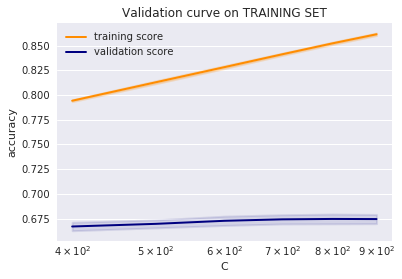

Best ['C'] = {'C': 800} with score : 0.674675
Execution time : 3467.376880645752 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([400, 500, 600, 700, 800, 900])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [40]:
parameter_search(SVC(),
                {'C':np.arange(400,1000,100)},
                X_train,
                y_train,save_file='output_figs/svm_more_accurate.png')

50000 samples Best ['C'] = {'C': 800} with score : 0.674675
Execution time : 3467.376880645752 seconds

#### Logistic classifier

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=3.35981828628e-05 .............................................
[CV] C=3.35981828628e-05 .............................................
[CV] C=3.35981828628e-05 .............................................
[CV] .......................................... C=1e-05, total=  37.2s
[CV] C=3.35981828628e-05 .............................................
[CV] .......................................... C=1e-05, total=  39.3s
[CV] C=3.35981828628e-05 .............................................
[CV] .......................................... C=1e-05, total=  41.9s
[CV] C=0.000112

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min


[CV] C=0.0143844988829 ...............................................
[CV] ............................... C=0.00428133239872, total= 1.6min
[CV] C=0.0143844988829 ...............................................
[CV] ............................... C=0.00428133239872, total= 1.7min
[CV] C=0.0143844988829 ...............................................
[CV] ............................... C=0.00428133239872, total= 1.5min
[CV] C=0.0483293023857 ...............................................
[CV] ............................... C=0.00428133239872, total= 1.7min
[CV] C=0.0483293023857 ...............................................
[CV] ............................... C=0.00428133239872, total= 1.6min
[CV] C=0.0483293023857 ...............................................
[CV] ................................ C=0.0143844988829, total= 2.1min
[CV] C=0.0483293023857 ...............................................
[CV] ................................ C=0.0143844988829, total= 2.0min
[CV] C

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 160.3min finished
/home/adrikiri/project-pace-mourad/adrian/src/plots.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if train_scores_std != None and val_scores_std != None:
/home/adrikiri/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


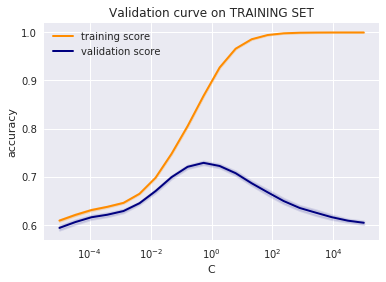

Best ['C'] = {'C': 0.54555947811685146} with score : 0.728919270833
Execution time : 9703.123768568039 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-05,   3.35982e-05,   1.12884e-04,   3.79269e-04,
         1.27427e-03,   4.28133e-03,   1.43845e-02,   4.83293e-02,
         1.62378e-01,   5.45559e-01,   1.83298e+00,   6.15848e+00,
         2.06914e+01,   6.95193e+01,   2.33572e+02,   7.84760e+02,
         2.63665e+03,   8.85867e+03,   2.97635e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [176]:
parameter_search(LogisticRegression(),
                {'C':np.logspace(-5,5,20)},
                X_train,
                y_train, save_file='output_figs/log_reg.png')

run with 5000 samples got 0.59 accuracy and C= 0.74438

50000 samples Best ['C'] = {'C': 0.74438030132516808} with score : 0.6947
Execution time : 10005.617159843445 seconds

all samples, tfidf, scaled Best ['C'] = {'C': 0.54555947811685146} with score : 0.728919270833

all samples, tfidf, not scaled same

We can conclude that the parameter C stays the same ! Let's try more precise

Fitting 5 folds for each of 23 candidates, totalling 115 fits
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] ........................................... C=0.05, total= 2.4min
[CV] C=0.1 ...........................................................
[CV] ........................................... C=0.05, total= 2.5min
[CV] C=0.1 ...........................................................
[CV] ........................................... C=0.05, total= 2.6min
[CV] C=0.15 ...

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.1min


[CV] C=0.35 ..........................................................
[CV] ............................................ C=0.3, total= 3.8min
[CV] C=0.35 ..........................................................
[CV] ............................................ C=0.3, total= 3.8min
[CV] C=0.35 ..........................................................
[CV] ............................................ C=0.3, total= 4.1min
[CV] C=0.4 ...........................................................
[CV] ............................................ C=0.3, total= 3.8min
[CV] C=0.4 ...........................................................
[CV] ............................................ C=0.3, total= 3.7min
[CV] C=0.4 ...........................................................
[CV] ........................................... C=0.35, total= 4.2min
[CV] C=0.4 ...........................................................
[CV] ........................................... C=0.35, total= 4.4min
[CV] C

[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed: 64.0min finished
/home/adrikiri/project-pace-mourad/adrian/src/plots.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if train_scores_std != None and val_scores_std != None:
/home/adrikiri/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


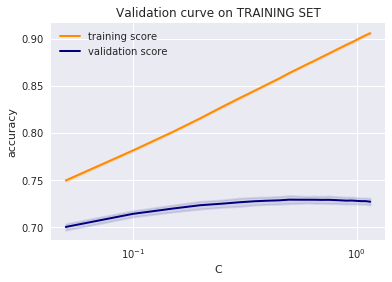

Best ['C'] = {'C': 0.5} with score : 0.729049479167
Execution time : 3922.019577741623 seconds


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ,  1.05,  1.1 ,  1.15])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [151]:
parameter_search(LogisticRegression(),
                {'C':np.arange(0.05,1.2,0.05)},
                X_train,
                y_train, save_file='output_figs/log_reg_more accurate.png',n_jobs=-1)

50000 Samples, more precise range : Best ['C'] = {'C': 0.90000000000000013} with score : 0.6951
Execution time : 1714.0209708213806 seconds

all samples, tfidf, scaled Best ['C'] = {'C': 0.5} with score : 0.729049479167
Execution time : 3922.019577741623 seconds

Trying prediction on all data

In [101]:
from sklearn.model_selection import cross_val_score


start= time.time()
log_reg=LogisticRegression(C=0.9)
print("Mean CV valdiation score:",np.mean(cross_val_score(
    log_reg,X_train,y_train,scoring='accuracy',cv=5,verbose=2,n_jobs=-1)))
end=time.time()
print("Execution time : {} seconds".format(end-start))


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 4.0min
[CV] ................................................. , total= 4.1min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.2min


[CV] ................................................. , total= 4.1min
[CV] ................................................. , total= 4.2min
[CV] ................................................. , total= 4.2min
Mean CV valdiation score: 0.719231482298
Execution time : 257.18780183792114 seconds


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished


min_df=15, max_df=0.4,  0.71783822738

no min no max 0.719231482298

In [ ]:
from sklearn.model_selection import cross_val_score


start= time.time()
svc=SVC(C=800)
print("Mean CV valdiation score:",np.mean(cross_val_score(
    svc,X_train,y_train,scoring='accuracy',cv=5,verbose=2,n_jobs=-1)))
end=time.time()
print("Execution time : {} seconds".format(end-start))


write down the accuracy then try decreasing df_min and max !!